In [1]:
import torch
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from model_factory import ModelFactory
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

Load model and validation data

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu" # uncomment this line if you have enough GPU memory

model = ModelFactory.DenoiseCNN(None)
model = model.to(device)
state_dict = torch.load("models/DenoiseCNN.pth")
model.load_state_dict(state_dict)
# Set the model to evaluation mode
model.eval()

raw_data = np.load("data_npy/raw_data_validation_nonorm.npy").astype(np.float32)
clean_data = np.load("data_npy/clean_data_validation_nonorm.npy").astype(np.float32)

# Test the model on the whole sample

## Load raw and clean data of subject 044
Take the whole recording

In [3]:
raw_044 = mne.io.read_raw_eeglab(
        "./data_raw/sub-044/eeg/sub-044_task-eyesclosed_eeg.set",
        preload=True,
    )
# use the same preprocessing steps and parameters as in the training
raw_044.resample(250) 
raw_044 = raw_044.copy().filter(l_freq=0.5, h_freq=45, verbose=False).get_data().astype(np.float32)


clean_044 = mne.io.read_raw_eeglab(
        "./data_clean/sub-044/eeg/sub-044_task-eyesclosed_eeg.set",
        preload=True,
    )
# use the same preprocessing steps and parameters as in the training
clean_044.resample(250) 
clean_044 = clean_044.copy().filter(l_freq=0.5, h_freq=45, verbose=False).get_data().astype(np.float32)

Perform inference on the whole recording of subject 044

In [4]:
raw_044_tensor = torch.from_numpy(raw_044).to(device)
predicted_044 = model(raw_044_tensor).detach().cpu().numpy()

Plot the predicted signal

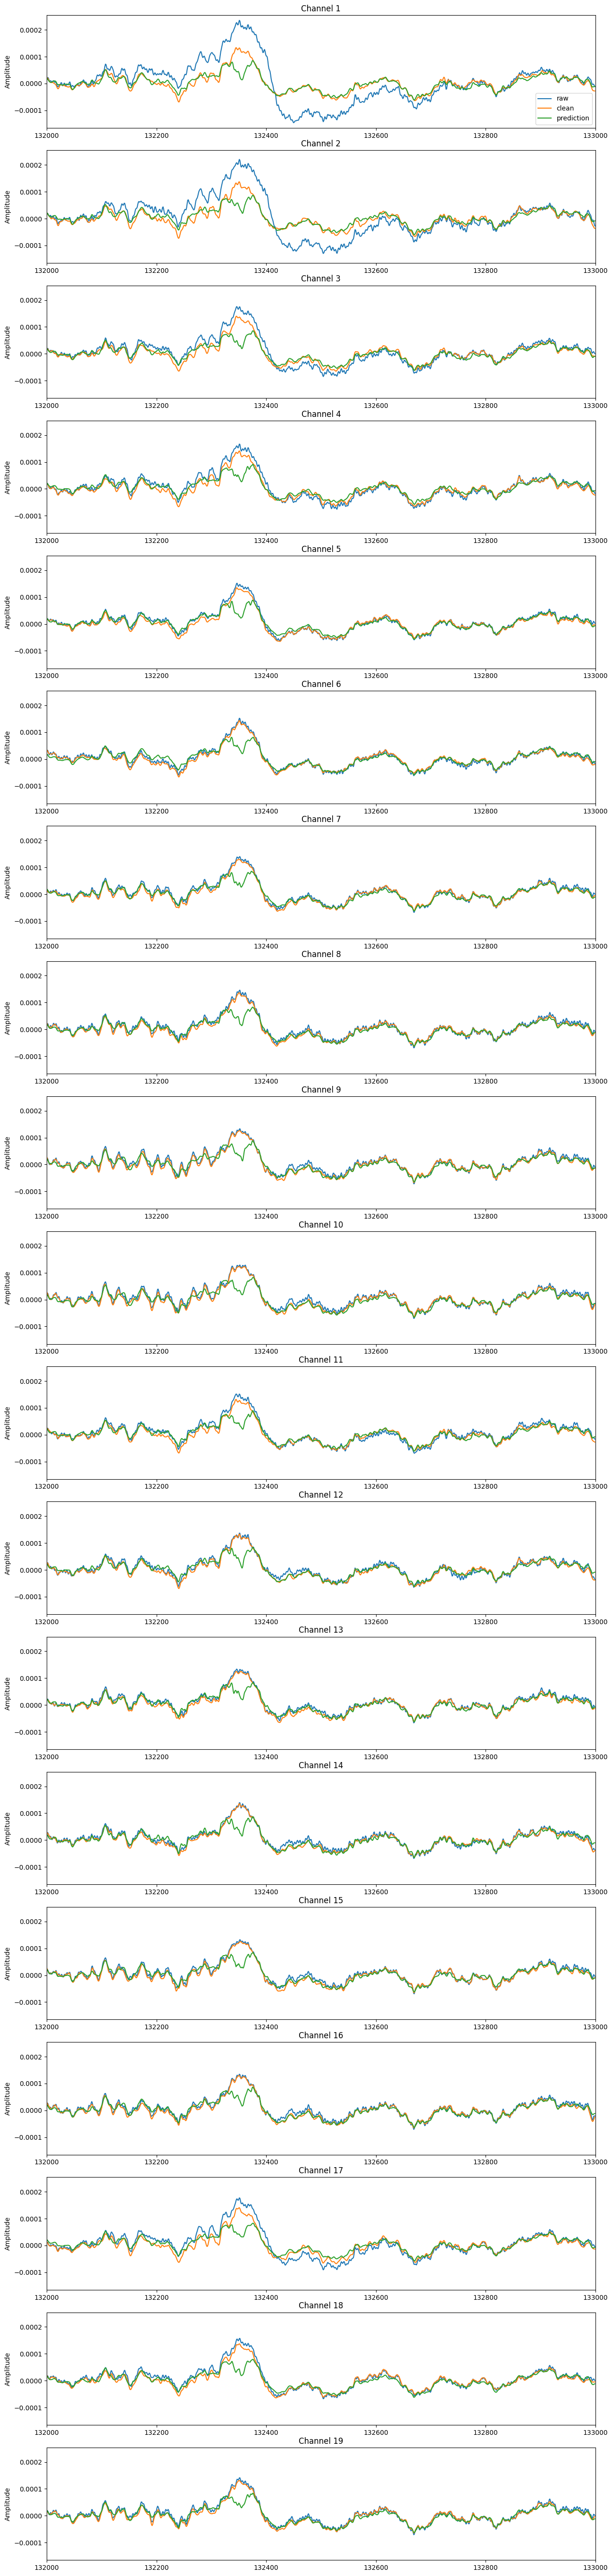

In [5]:
# M = 10300
# N = 10900

# M = 74250
# N = 75250

M = 132_000
N = 133_000

# M = 136_500
# N = 137_500


CHANNELS=19

fig, axs = plt.subplots(CHANNELS, 1, figsize=(15, 70), sharey=True)

for i in range(CHANNELS):
    data = {"raw": raw_044[i], "clean": clean_044[i], "prediction": predicted_044[i]}
    df = pd.DataFrame(data)
    df = df.iloc[M:N]

    axs[i].plot(df['raw'], label='raw')
    axs[i].plot(df['clean'], label='clean')
    axs[i].plot(df['prediction'], label='prediction')
    axs[i].set_title("Channel " + str(i + 1))
    # axs[i].set_xlabel("Time")
    axs[i].set_xlim(M, N)
    axs[i].set_ylabel("Amplitude")

axs[0].legend(loc='lower right')

plt.show()

Plot single channel

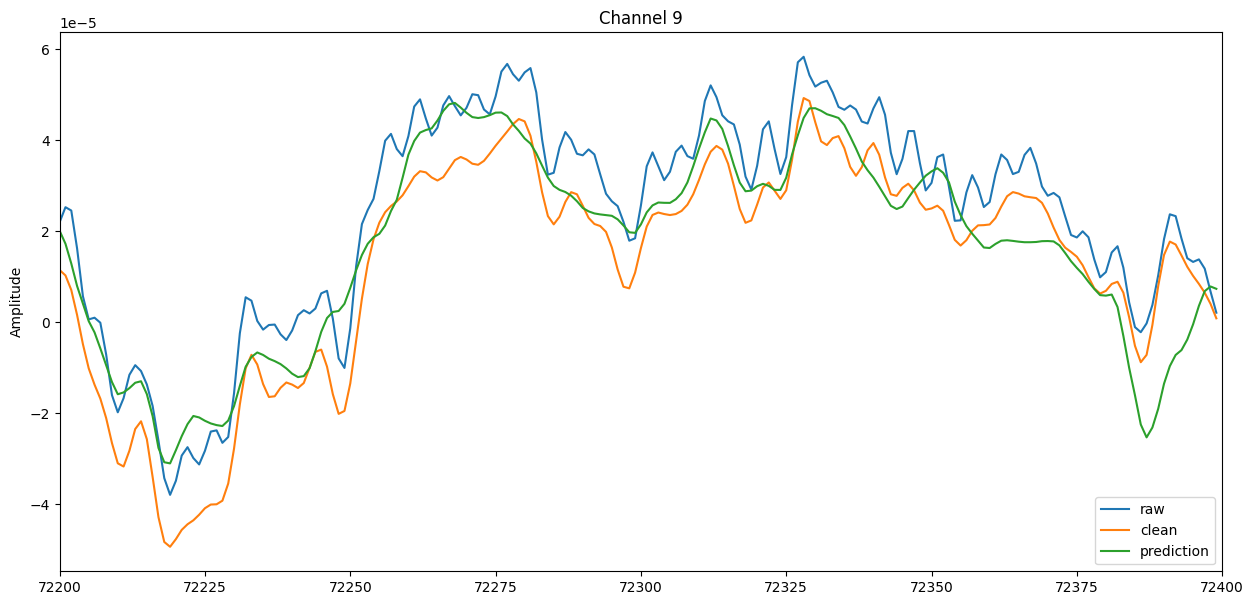

In [6]:
CHANNELS=19

fig, axs = plt.subplots(1, 1, figsize=(15, 7), sharey=True)

M = 72200
N = 72400

chnl = 8

data = {"raw": raw_044[chnl], "clean": clean_044[chnl], "prediction": predicted_044[chnl]}
df = pd.DataFrame(data)
df = df.iloc[M:N]

axs.plot(df['raw'], label='raw')
axs.plot(df['clean'], label='clean')
axs.plot(df['prediction'], label='prediction')
axs.set_title("Channel " + str(chnl + 1))
# ai].set_xlabel("Time")
axs.set_xlim(M, N)
axs.set_ylabel("Amplitude")

axs.legend(loc='lower right')

plt.show()

## Calculate R2, MAE, MSE, RMSE

In [7]:


avg_r2 = 0
avg_mae = 0
avg_mse = 0
avg_rmse = 0

print(f"Iter\tR2\tMAE\t\tMSE\t\tRMSE")

for i in range(CHANNELS):
    y_true = clean_044[i] # True values
    y_pred = predicted_044[i] # Predicted values

    # Calculate the R2 score
    r2 = r2_score(y_true, y_pred)
    avg_r2 += r2

    # Calculate the MAE
    mae = np.mean(np.abs(y_true - y_pred))
    avg_mae += mae

    # Calculate the MSE
    mse = mean_squared_error(y_true, y_pred)
    avg_mse += mse

    # Calculate the RMSE
    rmse = np.sqrt(mse)
    avg_rmse += rmse


    # Print the result
    print(f"{i:>4}:\t{r2:.2f}\t{mae:.2e}\t{mse:.2e}\t{rmse:.2e}")


avg_r2 /= CHANNELS
avg_mae /= CHANNELS
avg_mse /= CHANNELS
avg_rmse /= CHANNELS

print(f"Mean:\t{avg_r2:.2f}\t{avg_mae:.2e}\t{avg_mse:.2e}\t{avg_rmse:.2e}")


Iter	R2	MAE		MSE		RMSE
   0:	0.90	8.11e-06	1.06e-10	1.03e-05
   1:	0.88	8.92e-06	1.27e-10	1.13e-05
   2:	0.90	7.66e-06	9.56e-11	9.78e-06
   3:	0.87	8.98e-06	1.29e-10	1.13e-05
   4:	0.93	6.21e-06	6.36e-11	7.98e-06
   5:	0.91	7.35e-06	8.82e-11	9.39e-06
   6:	0.92	7.28e-06	8.63e-11	9.29e-06
   7:	0.92	7.08e-06	8.15e-11	9.03e-06
   8:	0.85	1.02e-05	1.72e-10	1.31e-05
   9:	0.85	1.02e-05	1.70e-10	1.30e-05
  10:	0.91	7.65e-06	9.49e-11	9.74e-06
  11:	0.89	8.42e-06	1.13e-10	1.06e-05
  12:	0.91	7.42e-06	9.49e-11	9.74e-06
  13:	0.91	7.27e-06	8.57e-11	9.26e-06
  14:	0.89	8.55e-06	1.19e-10	1.09e-05
  15:	0.91	7.58e-06	9.32e-11	9.66e-06
  16:	0.89	8.13e-06	1.06e-10	1.03e-05
  17:	0.90	7.87e-06	9.98e-11	9.99e-06
  18:	0.91	7.63e-06	9.47e-11	9.73e-06
Mean:	0.90	8.02e-06	1.06e-10	1.02e-05
